<a href="https://colab.research.google.com/github/rakshitgupta22/EcoSort/blob/main/Garbage_Classification_InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Mounting Google Drive to Access Image Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


###Importing Necessary Libraries

In [ ]:
import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import sys
import time
import tensorflow as tf
import re
from tensorflow import keras as ks

In [ ]:
from PIL import Image
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, Input, GlobalAveragePooling2D, Dropout, Activation, BatchNormalization
from tensorflow.keras.applications import mobilenet_v2 as mobilenetv2
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Lambda
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

###Dataset Preparation
Setting Image Dimensions and naming classes

In [ ]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3


# Path where our data is located
base_path = "/content/drive/MyDrive/CS267Project/garbage_classification/"

# Dictionary to save our 12 classes
categories = {0: 'paper', 1: 'cardboard', 2: 'plastic', 3: 'metal', 4: 'trash', 5: 'battery',
              6: 'shoes', 7: 'clothes', 8: 'green-glass', 9: 'brown-glass', 10: 'white-glass',
              11: 'biological'}

In [ ]:
os.path.exists(base_path)

True

###Create DataFrame

In [ ]:
# Add class name prefix to filename. So for example "/paper104.jpg" become "paper/paper104.jpg"
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df

# list conatining all the filenames in the dataset
filenames_list = []
# list to store the corresponding category, note that each folder of the dataset has one class of data
categories_list = []

for category in categories:
    filenames = os.listdir(base_path + categories[category])

    filenames_list = filenames_list  +filenames
    categories_list = categories_list + [category] * len(filenames)

df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

df = add_class_name_prefix(df, 'filename')

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

print('number of elements = ' , len(df))

number of elements =  14759


In [ ]:
num_category_7 = df[df['category'] == 7].shape[0]
print('Number of samples in category 7:', num_category_7)


Number of samples in category 7: 4539


In [ ]:
plt.figure(figsize=(15,15))
for i in range(9):
    random_row = random.randint(0, len(df)-1)
    sample = df.iloc[random_row]
    random_image = tf.keras.utils.load_img(base_path + sample['filename'])
    plt.subplot(330 + 1 + i)
    plt.title(sample['category'])
    plt.imshow(random_image)
plt.show()

###Displaying Sample image

clothes/clothes614.jpg


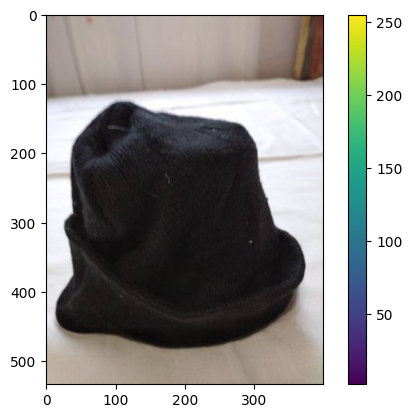

In [ ]:
# see sample image, you can run the same cell again to get a different image
random_row = random.randint(0, len(df)-1)
sample = df.iloc[random_row]
randomimage = image.load_img(base_path +sample['filename'])
print(sample['filename'])
plt.imshow(randomimage)
plt.colorbar()
plt.grid(False)
plt.show()

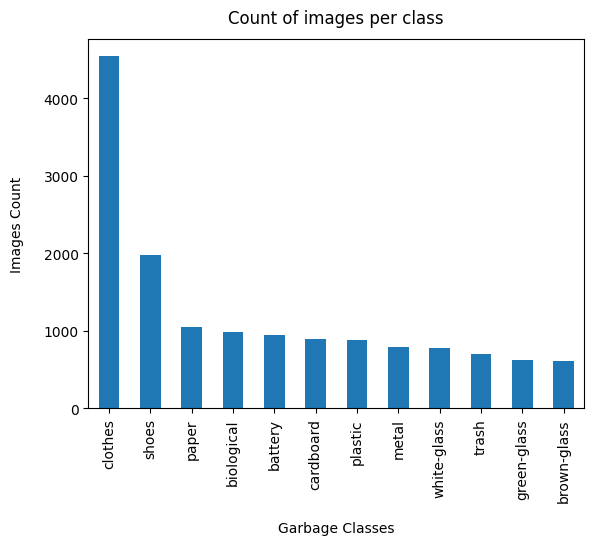

In [ ]:
df_visualization = df.copy()
# Change the catgegories from numbers to names
df_visualization['category'] = df_visualization['category'].apply(lambda x:categories[x] )

df_visualization['category'].value_counts().plot.bar(x = 'count', y = 'category' )

plt.xlabel("Garbage Classes", labelpad=14)
plt.ylabel("Images Count", labelpad=14)
plt.title("Count of images per class", y=1.02);

In [ ]:
clothesDrop=df[df['category']==7].sample(n=3539)
shoesDrop=df[df['category']==6].sample(n=1000)


df.drop(labels=clothesDrop.index.values, inplace=True)
df.drop(labels=shoesDrop.index.values, inplace=True)
df['category'].value_counts()

0     1050
7     1000
11     985
6      977
5      945
1      891
2      876
3      788
10     775
4      697
8      629
9      607
Name: category, dtype: int64

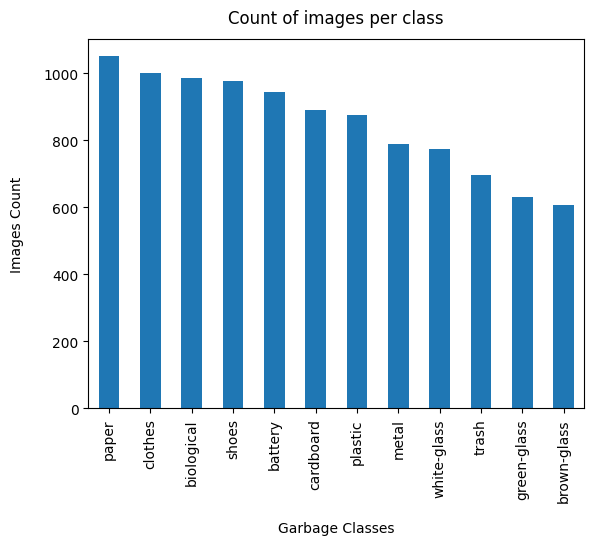

In [ ]:
df_visualization = df.copy()
# Change the catgegories from numbers to names
df_visualization['category'] = df_visualization['category'].apply(lambda x:categories[x] )

df_visualization['category'].value_counts().plot.bar(x = 'count', y = 'category' )

plt.xlabel("Garbage Classes", labelpad=14)
plt.ylabel("Images Count", labelpad=14)
plt.title("Count of images per class", y=1.02);

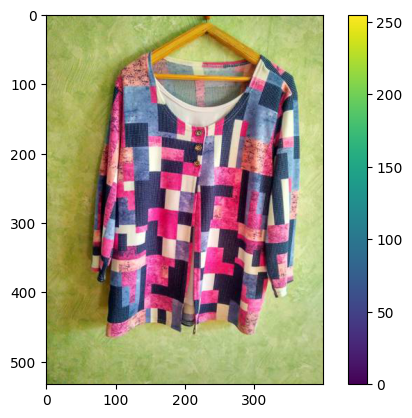

In [ ]:
from PIL import Image

# Load the first image in the dataset
img = Image.open(base_path + df['filename'][3])
# Convert the image to a numpy array
img_array = np.array(img)
plt.imshow(img_array)
plt.colorbar()
plt.grid(False)
plt.show()

###VGG19 Transfer Learning

In [ ]:
(IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS)

(224, 224, 3)

In [ ]:
# Import the necessary libraries for InceptionV3
from tensorflow.keras.applications import InceptionV3

# Replace the MobileNetV2 model with InceptionV3
inceptionv3_layer = InceptionV3(include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS), weights='imagenet')

# We don't want to train the imported weights
inceptionv3_layer.trainable = False

model = Sequential()
model.add(ks.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))

# Create a custom layer to apply InceptionV3's preprocessing
def inceptionv3_preprocessing(img):
    return tf.keras.applications.inception_v3.preprocess_input(img)

model.add(Lambda(inceptionv3_preprocessing))

model.add(inceptionv3_layer)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(len(categories), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=ks.optimizers.Adam(), metrics=['categorical_accuracy'])
model.summary()


87910968/87910968 [==============================] - 5s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 12)                24588     
                                                                 
Total params: 21,827,372
Trainable params: 24,588
Non-trainable params: 21,802,784
_________________________________________________________________


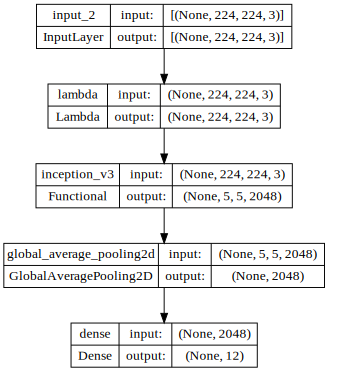

In [ ]:
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, dpi=75).create(prog='dot', format='svg'))

In [ ]:
early_stop = EarlyStopping(patience = 2, verbose = 1, monitor='val_categorical_accuracy',
                           mode='max', min_delta=0.001, restore_best_weights = True)

callbacks = [early_stop]

###Create Train, Test and Validation sets (80% 10% 10%)

In [ ]:
#Change the categories from numbers to names
df["category"] = df["category"].replace(categories)

# We first split the data into two sets and then split the validate_df to two sets
train_df, validate_df = train_test_split(df, test_size=0.2, random_state=42)
validate_df, test_df = train_test_split(validate_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

print('train size = ', total_train , 'validate size = ', total_validate, 'test size = ', test_df.shape[0])

train size =  8176 validate size =  1022 test size =  1022


In [ ]:
batch_size=64

train_datagen = image.ImageDataGenerator(

    ###  Augmentation Start  ###

    rotation_range=30,
    shear_range=0.1,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip = True,
    width_shift_range=0.2,
    height_shift_range=0.2

    ##  Augmentation End  ###
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 8176 validated image filenames belonging to 12 classes.


In [ ]:
validation_datagen = image.ImageDataGenerator()

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1022 validated image filenames belonging to 12 classes.


###Train Model

In [ ]:
EPOCHS = 20
history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

<ipython-input-49-97b72bb738e0>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/20
127/127 [==============================] - 1056s 8s/step - loss: 1.0294 - categorical_accuracy: 0.6787 - val_loss: 0.5088 - val_categorical_accuracy: 0.8354
Epoch 2/20
127/127 [==============================] - 126s 989ms/step - loss: 0.5635 - categorical_accuracy: 0.8192 - val_loss: 0.4224 - val_categorical_accuracy: 0.8615
Epoch 3/20
127/127 [==============================] - 124s 979ms/step - loss: 0.5013 - categorical_accuracy: 0.8369 - val_loss: 0.4051 - val_categorical_accuracy: 0.8760
Epoch 4/20
127/127 [==============================] - 125s 982ms/step - loss: 0.4657 - categorical_accuracy: 0.8531 - val_loss: 0.4044 - val_categorical_accuracy: 0.8792
Epoch 5/20
127/127 [==============================] - 125s 983ms/step - loss: 0.4303 - categorical_accuracy: 0.8554 - val_loss: 0.3538 - val_categorical_accuracy: 0.8792
Epoch 6/20
127/127 [==============================] - 129s 1s/step - loss: 0.4040 - categorical_accuracy: 0.8669 - val_loss: 0.3347 - val_categorical_ac

In [ ]:
model.save_weights("/content/drive/MyDrive/CS267Project/trained_model.h5")

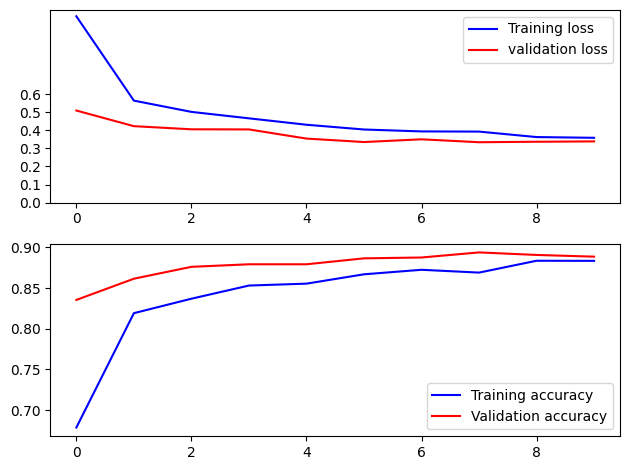

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_yticks(np.arange(0, 0.7, 0.1))
ax1.legend()

ax2.plot(history.history['categorical_accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_categorical_accuracy'], color='r',label="Validation accuracy")
ax2.legend()

legend = plt.legend(loc='best')
plt.tight_layout()
plt.show()

###Model Evaluation

In [ ]:
test_datagen = image.ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    dataframe= test_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False
)

filenames = test_generator.filenames
nb_samples = len(filenames)

_, accuracy = model.evaluate_generator(test_generator, nb_samples)

print('Accuracy on test set = ',  round((accuracy * 100),2 ), '% ')

Found 1022 validated image filenames belonging to 12 classes.


<ipython-input-52-f40a70fea481>:18: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  _, accuracy = model.evaluate_generator(test_generator, nb_samples)


Accuracy on test set =  88.65 % 


In [ ]:
# We defined at the beginning of this notebook a dictionary that maps the categories number to names, but the train generator
# generated it's own dictionary and it has assigned different numbers to our categories and the predictions made by the model
# will be made using the genrator's dictionary.

gen_label_map = test_generator.class_indices
gen_label_map = dict((v,k) for k,v in gen_label_map.items())
print(gen_label_map)

{0: 'battery', 1: 'biological', 2: 'brown-glass', 3: 'cardboard', 4: 'clothes', 5: 'green-glass', 6: 'metal', 7: 'paper', 8: 'plastic', 9: 'shoes', 10: 'trash', 11: 'white-glass'}


In [ ]:
list(gen_label_map.values())

['battery',
 'biological',
 'brown-glass',
 'cardboard',
 'clothes',
 'green-glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash',
 'white-glass']

In [ ]:
# get the model's predictions for the test set
preds = model.predict_generator(test_generator, nb_samples)

# Get the category with the highest predicted probability, the prediction is only the category's number and not name
preds = preds.argmax(1)

# Convert the predicted category's number to name
preds = [gen_label_map[item] for item in preds]

# Convert the pandas dataframe to a numpy matrix
labels = test_df['category'].to_numpy()

print(classification_report(labels, preds))


<ipython-input-55-2567a85855db>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_generator, nb_samples)


              precision    recall  f1-score   support

     battery       0.96      0.94      0.95        90
  biological       0.95      1.00      0.97        94
 brown-glass       0.78      0.85      0.81        72
   cardboard       0.90      0.93      0.91        84
     clothes       0.98      0.96      0.97       105
 green-glass       0.94      0.68      0.79        68
       metal       0.72      0.80      0.76        70
       paper       0.96      0.87      0.91       108
     plastic       0.72      0.83      0.77        95
       shoes       0.96      0.99      0.97        97
       trash       0.94      0.92      0.93        74
 white-glass       0.80      0.74      0.77        65

    accuracy                           0.89      1022
   macro avg       0.88      0.88      0.88      1022
weighted avg       0.89      0.89      0.89      1022



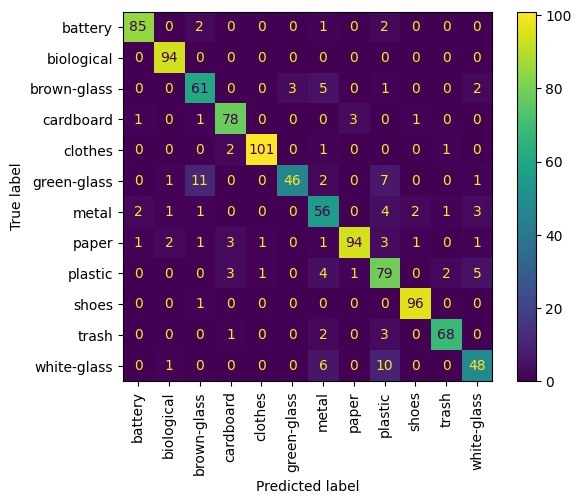

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(labels, preds, display_labels=list(gen_label_map.values()), xticks_rotation = 'vertical')

In [ ]:
model.save("/content/drive/MyDrive/CS267Project/inception_trained")